## CS 6120: Natural Language Processing - Prof. Ahmad Uzair

### Assignment 1: Naive Bayes
### Total Points: 100 points

You will be dealing with movie review data that includes both positive and negative reviews in this assignment. You will use Sentiment Analysis to assess if a given review is positive or negative using the provided dataset.

Therefore, we will make use of Naive Bayes algorithm to perform sentiment analysis on the movie review dataset.

## Importing the Libraries

In [3]:
import numpy as np
import math
import pandas as pd
import re
import string
import nltk
import json
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

## Reading the data

When reading the data, ensure that the '.csv' file is in the same location where your jupyter notebook is used. This way the files are organized and easy to read using the pandas library. 

In [4]:
## Reading the data and removing columns that are not important. 
#y_hats = []
df = pd.read_csv("movie_reviews.csv", sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [5]:
# print head of data frame with help of head function
df.head() 

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,"Probably my all-time favorite movie, a story o...",positive


## Count plot of the output categories: positive or negative

Feel free to take a look at the output and whether the classes are balanced or imbalanced. 

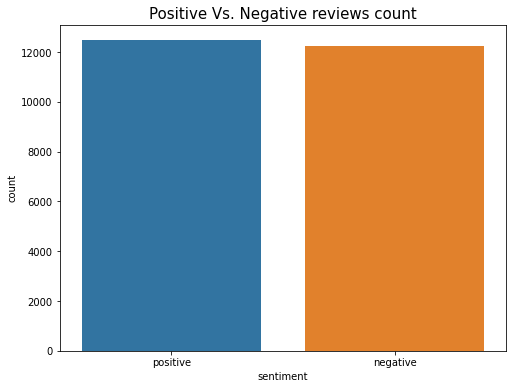

In [6]:
plt.figure(figsize = [8, 6])
sns.countplot(x="sentiment", data = df)
plt.title("Positive Vs. Negative reviews count", fontsize = 15)
plt.show()


## Upsampling the minority class: (5 points)

It is known that Naive bayes is not robust to class imbalance. It could be seen above that the data is little imbalanced. Therefore, class balancing can be done before giving it to the Naive Bayes model for prediction. 

Feel free to use 'resample' library from sklearn. 

In [7]:
## hint: use resample from sklearn.utils
from sklearn.utils import resample

df_majority = df[df['sentiment']=="positive"]
df_minority = df[df['sentiment']=="negative"]

negative_upsample = resample(df_minority, replace = True, 
                        n_samples = df_majority.shape[0],
                        random_state = 101)

df_upsampled = pd.concat([negative_upsample, df_majority])  # concat two data frames i,e majority class data set and upsampled minority class data set
df_upsampled = df_upsampled.sample(frac = 1)

In [8]:
## Just to ensure that upsampling was done successfully, take a look at the shape of the data in 
## this cell. 

# print the shape of data set with the help of shape function having "negative" as class label
df_upsampled[df_upsampled["sentiment"]=="negative"].shape

(12474, 2)

### Expected Output : 
(12474, 2)

In [9]:
## Ensure that the same number of data points are present for both 'positive' and 'negative' data

# print the shape of data set with the help of shape function having "positive" as class label
df_upsampled[df_upsampled["sentiment"]=="positive"].shape

(12474, 2)

### Expected Output : 
(12474, 2)

In [10]:
## In this cell, we are going to be dividing the data into train and test points
## Ensure that you store the upsampled data in a variable called 'df_upsampled' 
## so that the below operations are performed successfully


## Considering 10000 positive and 10000 negative data points
negative_data_points_train = df_upsampled[df_upsampled["sentiment"]=="negative"].iloc[0:10000]
positive_data_points_train = df_upsampled[df_upsampled["sentiment"]=="positive"].iloc[0:10000]

## Considering the remaining data points for test
negative_data_points_test = df_upsampled[df_upsampled["sentiment"]=="negative"].iloc[10000:]
positive_data_points_test = df_upsampled[df_upsampled["sentiment"]=="positive"].iloc[10000:]

## Concatenate the training positive and negative reviews
x_train = pd.concat([negative_data_points_train['review'], positive_data_points_train['review']])
## Concatenating the training positive and negative outputs
y_train = pd.concat([negative_data_points_train['sentiment'], positive_data_points_train['sentiment']])

## Concatenating the test positive and negative reviews
x_test = pd.concat([negative_data_points_test['review'], positive_data_points_test['review']])
## Concatenating the test positive and negative outputs
y_test = pd.concat([negative_data_points_test['sentiment'], positive_data_points_test['sentiment']])


In [11]:
## Take a look at the total number of classes and their count using '.value_counts()' for y_train and y_test.
## Ensure that there are equal number of positive and negative reviews. 
y_train.value_counts()

negative    10000
positive    10000
Name: sentiment, dtype: int64

### Expected Output:
negative    10000<br>
positive    10000<br>
Name: sentiment, dtype: int64

In [12]:
y_test.value_counts()

negative    2474
positive    2474
Name: sentiment, dtype: int64

### Expected Output : 
negative    2474<br>
positive    2474<br>
Name: sentiment, dtype: int64

## Q1. Pre-process the reviews: (10 points)

We know that a review contains links, punctuation, stopwords and many other words that don't give a lot of meaning for the Naive Bayes model for prediction. 

In the cell below, one must implement text-preprocessing and remove links, punctuations and stopwords. It is also important to lowercase the letters so that 'Admire' and 'admire' are not treated as different words. 

In addition to this, perform stemming operation so that similar words are reduced. To know more about stemming, feel free to take a look at this link.

https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

In [13]:
# TASK CELL

def clean_review(review):
    
    '''
    Input:
        review: a string containing a review.
    Output:
        review_cleaned: a processed review. 
    '''
    #To remove punctuation
    review_processed = ""
    for word in review:
        if word not in string.punctuation:
            review_processed += "".join(word)
     #To make lower case
    review_processed = review_processed.lower()
     #Tokenization
    review_processed = word_tokenize( review_processed)

     #Stop word removal
    review_clean= []
    stopwords = nltk.corpus.stopwords.words('english')
    for word in review_processed:
        if word not in stopwords:
            review_clean.append(word)
    
    #Stemming
    reviews_cleaned= []
    porter_stemmer = PorterStemmer()
    for word in review_clean:
        reviews_cleaned.append(porter_stemmer.stem(word))
        
    return reviews_cleaned

## Q2. Implement a find_occurrence function (5 points):

In this function, we find the total occurrence of a word giving information such as label, word and frequency dictionary.

Note that this function is used later in the code when we are going to be predicting the output using Naive Bayes. 

In [14]:
# TASK CELL
def find_occurrence(frequency, word, label):
    '''
    Params:
        frequency: a dictionary with the frequency of each pair (or tuple)
        word: the word to look up
        label: the label corresponding to the word
    Return:
        n: the number of times the word with its corresponding label appears.
    '''
  
    try:
        n = frequency[(word,label)]
    except:
        n = 0
    return n

### Converting output to numerical format:

We have outputs as 'positive' or 'negative'. In the cell below, we convert it to a numerical format. 

In [15]:
## With the use of mapping function, we replace
## the label in the form of string to an integer. 

output_map = {'positive': 0, 'negative': 1}
y_train = y_train.map(output_map)
y_test = y_test.map(output_map)

In [16]:
## Ensuring that there are equal number of classes on the training data. 
y_train.value_counts()

1    10000
0    10000
Name: sentiment, dtype: int64

In [17]:
## Choosing a random review and taking a look at it.
x_train.iloc[0]

"Was there a single positive to this film? Critics who knew nothing of video games could spot the gaming errors made. No damage taken with damage clearly visible towards the beginning being a primary example.<br /><br />And I may have missed something, but wasn't Super Mario Bros. 3 suppose to be a game that had never played before? Well if that IS the case, and I did not miss anything... how did Fred Savage's character, and even the girl, know so much about the game already? We're talking things that some people don't know about by their second or third play-through.<br /><br />Beyond the factual and gaming errors there is the general low quality of the film itself. Nothing here is honestly very memorable. The kid wasn't even that good at playing video games in the footage they showed. A lot of kids I knew way back in those days were significantly more experienced. On top of all this the acting and storyline are just mediocre at their strongest points. The characters are bland and com

From the above cell output, it could be seen that there are a lot of words that don't add a lot of meaning to the text. 

Therefore, those words would be removed. It also reduces the computation time. 

Therefore, it is a good practice we are following.

In [18]:
custom_review = x_train.iloc[0]
# print cleaned review
print(clean_review(custom_review))

['singl', 'posit', 'film', 'critic', 'knew', 'noth', 'video', 'game', 'could', 'spot', 'game', 'error', 'made', 'damag', 'taken', 'damag', 'clearli', 'visibl', 'toward', 'begin', 'primari', 'examplebr', 'br', 'may', 'miss', 'someth', 'wasnt', 'super', 'mario', 'bro', '3', 'suppos', 'game', 'never', 'play', 'well', 'case', 'miss', 'anyth', 'fred', 'savag', 'charact', 'even', 'girl', 'know', 'much', 'game', 'alreadi', 'talk', 'thing', 'peopl', 'dont', 'know', 'second', 'third', 'playthroughbr', 'br', 'beyond', 'factual', 'game', 'error', 'gener', 'low', 'qualiti', 'film', 'noth', 'honestli', 'memor', 'kid', 'wasnt', 'even', 'good', 'play', 'video', 'game', 'footag', 'show', 'lot', 'kid', 'knew', 'way', 'back', 'day', 'significantli', 'experienc', 'top', 'act', 'storylin', 'mediocr', 'strongest', 'point', 'charact', 'bland', 'complet', 'uninterest', 'wizard', 'youngest', 'child', 'silent', 'complet', 'dri', 'child', 'clichã©', 'littl', 'kid', 'almost', 'never', 'talk', 'trauma', 'isnt', '

We now use this function to pre-process the review and remove words that don't add a lot of meaning in our model. 

## Q3. Implementing review counter function: (5 points)

It is now time to implement the count function for the reviews. 

In this function, we count the occurrence of words and get the probabilities 
for the words based on the training data. 

In other words, we get the probability of occurrence of a word, given that the output is 'positive'.

Similarly, we also compute the probability of occurence of a word, given that the output is 'negative'.



In [19]:
# TASK CELL
def review_counter(output_occurrence, reviews, sentiment):
    '''
    Params:
        output_occurrence: a dictionary that will be used to map each pair to its frequency
        reviews: a list of reviews
        positive_or_negative: a list corresponding to the sentiment of each review (either 0 or 1)
    Return:
        output: a dictionary mapping each pair to its frequency
    '''
    ## Steps :
    # define the key, which is the word and label tuple
    # if the key exists in the dictionary, increment the count
    # else, if the key is new, add it to the dictionary and set the count to 1
    
    for label, review in zip(sentiment, reviews):
        for word in clean_review(review):
            key = (word,label)
            if key in output_occurrence.keys():
                output_occurrence[key]+=1
            else:
                output_occurrence.update({key:1})
   
    return output_occurrence
   


### Test your function with example reviews:

Feel free to run the cell below and understand whether the above function that you have defined is producing the optimum results. 

In [20]:
# Testing your function

result = {}
reviews = ['got bored throught the moview', 'The movie was fantastic', 'Will not watch it again', 'Was bored, it was a complete waste of time and money', 'Enjoyed the movie to the fullest']
ys = [1, 0, 1, 1, 0]
review_counter(result,reviews, ys)

{('got', 1): 1,
 ('bore', 1): 2,
 ('throught', 1): 1,
 ('moview', 1): 1,
 ('movi', 0): 2,
 ('fantast', 0): 1,
 ('watch', 1): 1,
 ('complet', 1): 1,
 ('wast', 1): 1,
 ('time', 1): 1,
 ('money', 1): 1,
 ('enjoy', 0): 1,
 ('fullest', 0): 1}

### Expected Output:
 {('bored', 1): 2, <br>
 ('complete', 1): 1, <br>
 ('enjoyed', 0): 1, <br>
 ('fantastic', 0): 1, <br>
 ('fullest', 0): 1, <br>
 ('got', 1): 1, <br>
 ('money', 1): 1, <br>
 ('movie', 0): 2, <br>
 ('moview', 1): 1, <br>
 ('throught', 1): 1, <br>
 ('time', 1): 1, <br>
 ('waste', 1): 1, <br>
 ('watch', 1): 1}

In [21]:
# Build the freqs dictionary for later uses

freqs = review_counter({}, x_train, y_train)

In [22]:
## Run this cell to get an idea about the corpus of words and their occurrence along with labels. 
## In this, we are computing the frequency of occurrence of word given that a review is 'positive'.
## Similarly, we also compute the frequence of occurence of word given that a review is 'negative'.
freqs

{('singl', 1): 373,
 ('posit', 1): 389,
 ('film', 1): 17022,
 ('critic', 1): 314,
 ('knew', 1): 306,
 ('noth', 1): 2322,
 ('video', 1): 751,
 ('game', 1): 560,
 ('could', 1): 3638,
 ('spot', 1): 201,
 ('error', 1): 77,
 ('made', 1): 3338,
 ('damag', 1): 73,
 ('taken', 1): 344,
 ('clearli', 1): 370,
 ('visibl', 1): 34,
 ('toward', 1): 353,
 ('begin', 1): 1109,
 ('primari', 1): 41,
 ('examplebr', 1): 13,
 ('br', 1): 23291,
 ('may', 1): 1114,
 ('miss', 1): 870,
 ('someth', 1): 2242,
 ('wasnt', 1): 1093,
 ('super', 1): 159,
 ('mario', 1): 34,
 ('bro', 1): 27,
 ('3', 1): 705,
 ('suppos', 1): 1075,
 ('never', 1): 2733,
 ('play', 1): 2789,
 ('well', 1): 3076,
 ('case', 1): 660,
 ('anyth', 1): 1492,
 ('fred', 1): 73,
 ('savag', 1): 54,
 ('charact', 1): 5609,
 ('even', 1): 6173,
 ('girl', 1): 1619,
 ('know', 1): 3063,
 ('much', 1): 3881,
 ('alreadi', 1): 609,
 ('talk', 1): 902,
 ('thing', 1): 3705,
 ('peopl', 1): 3684,
 ('dont', 1): 4151,
 ('second', 1): 871,
 ('third', 1): 258,
 ('playthroughb

## Q4. Training the Naive Bayes Model: (20 points)

Now we are in the training phase of the Naive Bayes algorithm. In this cell, take a look at the ways to calculate the log likelihood and log prior values as these are important for testing in the next few cells. 

Also calculate the frequency of occurrence of words where the output is negative. In the same way, calculate the word frequency count using the above functions in order to compute the log likelihood.

Return the logprior and loglikelihood output by the model from this function. 

In [23]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of reviews
        train_y: a list of labels correponding to the reviews (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0


    # calculate V, the number of unique words in the vocabulary
    vocab = []
    for key in freqs.keys():
        if key[0] not in vocab:
            vocab.append(key[0])
    V = len(vocab)

    # calculate num_pos and num_neg - the total number of positive and negative words for all documents
    num_pos = num_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1]==1:

            # Increment the number of positive words by the count for this (word, label) pair
            num_pos = freqs[pair]

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            num_neg = freqs[pair]

    # Calculate num_doc, the number of documents
    num_doc = len(train_x)

    # Calculate D_pos, the number of positive documents 
    pos_num_docs = 0
    for i in train_y:
        if i==1:
            pos_num_docs+=1

    # Calculate D_neg, the number of negative documents 
    neg_num_docs = 0
    for i in train_y:
        if i==0:
            neg_num_docs+=1

    # Calculate logprior
    logprior = np.log(pos_num_docs)-np.log(neg_num_docs)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = find_occurrence(freqs,word,1)
        freq_neg = find_occurrence(freqs,word,0)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos+1)/(num_pos+V)
        p_w_neg = (freq_neg+1)/(num_neg+V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos/p_w_neg)


    return logprior, loglikelihood

In [24]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything
logprior, loglikelihood = train_naive_bayes(freqs, x_train, y_train)
print(logprior)
print(len(loglikelihood))

0.0
75779


### Expected Output 

0.0 <br>
91425

## Q5. Implementing Naive Bayes Predict Function: (10 points)

It is now time to make our prediction as to whether a given review is negative or positive respectively. 

After adding the log likelihood values, ensure that the output is 1 (negative) if the sum of the log likelihood value is greater than 0 and 0 (positive) if the sum of the log likelihood is less than or equal to 0. 

In [25]:
# TASK 4 CELL

def naive_bayes_predict(review, logprior, loglikelihood):
    '''
    Params:
        review: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Return:
        total_prob: the sum of all the loglikelihoods of each word in the review (if found in the dictionary) + logprior (a number)

    '''
    
      # process the review to get a list of words
    word_l = clean_review(review)

    # initialize probability to zero
    total_prob = 0

    # add the logprior
    total_prob = logprior

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood.keys():
            # add the log likelihood of that word to the probability
            total_prob += loglikelihood[word]

    if total_prob>0:
        total_prob=1
    else:
        total_prob=0


    return total_prob

In [26]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Experiment with your own review.
my_review = "I thought this series was going to be another fun, action series with some dynamic plots and great performances. I was wrong. While I like Jamie Denton, this show is hardly worth watching at all, unless you enjoy watching some people brutalized and the actions of the agents supposedly warranted under the theme of national security. The show is great propaganda for the current government, and spews out jingoism as though we talk that way every day. After a couple of episodes, it was boring the hell out of me, and I started watching reruns of House Invaders on BBCAmerica instead. Rather watch CSI and Without a Trace, without a doubt."
p = naive_bayes_predict(my_review, logprior, loglikelihood)
print('The expected output is', p)

The expected output is 0


### Expected Output :
The expected output is 1

## Q6. Implementing Naive Bayes Test function: (10 points)

In this function, implement the previous functions such as naive_bayes_predict to get the predictions for the test set. 

In addition to this, the function should return the total number of reviews that it correctly classified as 'positive' or 'negative'. 

In [27]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of reviews
        test_y: the corresponding labels for the list of reviews
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of reviews classified correctly)/(total # of reviews)
    """
    accuracy = 0  

    
    y_hats = []
    for review in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(review, logprior, loglikelihood)>0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y
    l = len(test_y)
    err = []
    for i in range(l):
        err.append(abs(y_hats[i]-test_y[i]))
    error = np.mean(err)

    accuracy = 1-error

  
    return accuracy,y_hats

In [28]:

#print(len(y_hats))
#print(len(test_y))
#print(len(test_x))

In [29]:
# For grading purpose only
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Run this cell to test your function

for review in ["If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",
                "What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative direction, too. Some VERY faint echoes of Fargo here, but it just doesn't come off.",
                "I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the romance between Joe and Jean keeps me on the edge of my seat, plus I still think Bryan Brown is the tops. Brilliant Film.",
                "Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value. About as unentertaining, uninstructive and just plain dull as a film can be."]:
    p = naive_bayes_predict(review, logprior, loglikelihood)
    print(f'{review[:100]} -> {p:.2f}')
    

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00


### Expected Output :

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00 <br>
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00<br>
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00 <br>
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00



In [30]:
# Feel free to check the sentiment of your own review below
my_review = 'The moview was very boring, I wanted to leave in the middle'
naive_bayes_predict(my_review, logprior, loglikelihood)

1

### Expected Output :
1

## Q7. Evaluate the accuracy (10 Points)
1. Split your data into training and test sets using random selection. Set the seed as parameter of the function so that user can select a different training and test set by changin seed.


2. Calculate model paramters with training set.

3. Print confusion matrix for training and test set.

4. Examine False Positive and False Negative cases and provide reasoning why they get misclassified.

In [31]:
def evaluate_dynamic_accuracy(seed):
    global df_upsampled

    df_upsampled = df_upsampled.sample(frac=1 , random_state=seed)
    negative_data_points_train = df_upsampled[df_upsampled["sentiment"]=="negative"].iloc[:10000]
    positive_data_points_train = df_upsampled[df_upsampled["sentiment"]=="positive"].iloc[:10000]

    negative_data_points_test= df_upsampled[df_upsampled["sentiment"]=="negative"].iloc[10000:]
    positive_data_points_test= df_upsampled[df_upsampled["sentiment"]=="positive"].iloc[10000:]

    x_train = pd.concat([negative_data_points_train.review,positive_data_points_train.review])
    y_train=pd.concat([negative_data_points_train.sentiment,positive_data_points_train.sentiment])

    x_test = pd.concat([negative_data_points_test.review,positive_data_points_test.review])
    y_test = pd.concat([negative_data_points_test.sentiment,positive_data_points_test.sentiment])

    print(y_train.value_counts())
    print(y_test.value_counts())

    output_map = {'positive':0 , 'negative':1}
    y_train=y_train.map(output_map)
    y_test=y_test.map(output_map)
    
    print("Check length of test x")
    print(len(x_test))

    print("Check lenth of test y")
    print(len(y_test))

    y_list = y_test.values
    ytrain_list=y_train.values
    freqs = review_counter({},x_train,y_train)
    logprior,loglikelihood = train_naive_bayes(freqs,x_train,y_train)
    accuracy,y_hats= test_naive_bayes(x_test,y_list,logprior,loglikelihood)
    accuracy_t,y_hats_t = test_naive_bayes(x_train, ytrain_list,logprior,loglikelihood)
   
    print("The model parameter after testing the data set")
    print("Print the accuracy of . Below are the results ")
    print(accuracy)
    return accuracy,y_hats,accuracy_t,y_hats_t
   




In [32]:
a,y,c,d=evaluate_dynamic_accuracy(1)
print(a)

negative    10000
positive    10000
Name: sentiment, dtype: int64
negative    2474
positive    2474
Name: sentiment, dtype: int64
Check length of test x
4948
Check lenth of test y
4948
The model parameter after testing the data set
Print the accuracy of . Below are the results 
0.8728779304769604
0.8728779304769604


In [33]:
print("Confusion matrix for the test set")
cf_matrix = confusion_matrix(y_test,y)
print(cf_matrix)
print("Confusion matrix for the train set")
cf_matrix_t = confusion_matrix(y_train,d)
print(cf_matrix_t)


Confusion matrix for the test set
[[2109  365]
 [ 264 2210]]
Confusion matrix for the train set
[[9130  870]
 [ 429 9571]]


In [34]:
fp = []
fn = []
index=0
for actual , predicted in zip(y_test,y):
    if actual==0 and predicted == 1:fn.append(index)
    if actual==1 and predicted == 0:fp.append(index)
    index +=1
print(f'False positive are {len(fp)}')
print(f'False negative are {len(fn)}')

# the reason that they are missclassified is beacuse of the functionalities that we have used in the clean review and also while 
# testing and training the data . It depends on how the model is trained and test using the clean review funtion as it is used
#  to clean the data and bring in the format which the computer can understand  Its the functionality of the stemmer and the 
# calculation of the probabilty that has been predicted and when its is compared with the actual one we do see the difference 
# in false postive and false negative 


False positive are 264
False negative are 365


# Q8. Modularize your calssifier (10 points)
1. Convert your code into a python module text_classifier.py

2. The user should be able to launch the application on command prompt using python test_classifier.py command. The module will automatically load the model paramters from a local file of your choice and be ready to take the input from user on command prompt. The program will preprocess user input, tokenize and predict the class.

3. Your module will take the input from user and output sentiment class in an indefinite loop. The output should printout the probabilities for each input token along with the final classification decision. Program will quit if user enters X.


In [35]:
# please refer the text_classifier.py and the log-prior json file for it 

# Q9. Theory Questions: (10 points)

1. Why is Laplace Smoothing or Additive Smoothing required while executing Naive Bayes operations, especially for text classification? Show how not having additive smoothing leads to bad outcomes by using an example of training and the test set. (10 points)

With text data, we might run into words that might never appear in the training set, this makes the probability of the word P(word | corpus) = 0. The intuition behind the smoothing is to ensure that our posterior probabilities are never zero, we add “alpha" to the numerator, and we add alpha*V to the denominator (V is the size of the vocabulary). So, in the case that we don’t have a particular word in our training set, the posterior probability comes out to (alpha + count)/ (N + alpha*V), instead of zero. Smoothing this way doesn't change the predictions since the probabilities of all the words are altered accordingly. We can observe that as alpha increases, the distribution turns uniform i.e., the probability value will tend to be 0.5 (i.e, it is equally likely that a word equals is a positive or negative). Empirically, alpha = 1 seems to be a very good value to solve the problem of zero probabilities in the Naive Bayes algorithm.

Example: 
Now let's say we have an review (“we”, “are”, “thrilled”, “to”, “have”, “you”, “onboard”) which your classifier rates very highly as "positive", say 

P(positive| “we”, “are”, “thrilled”, “to”, “have”, “you”, “onboard”) = 0.9
P(negative| “we”, “are”, “thrilled”, “to”, “have”, “you”, “onboard”) = 0.1

Now let’s say you have another review which is exactly same as the one before with one extra word (w) but let’s say this word hasn’t occured neither in training set of positive or negative words. Since the count of the word w is 0

P(Positive | w) = P(Negative | w) = 0
But since we have

P(Positive | “we”, “are”, “thrilled”, “to”, “have”, “you”, “onboard”, w) =  P(Positive | “we”, “are”, “thrilled”, “to”, “have”, “you”, “onboard”) * P(Positive | w) = 0.9 * 0

Similarly,

P(Negative | “we”, “are”, “thrilled”, “to”, “have”, “you”, “onboard”, w) =  P(Negative | “we”, “are”, “thrilled”, “to”, “have”, “you”, “onboard”) * P(Negative| w) = 0.1 * 0

We have the new email classified neither to positive or negative despite the fact that most of the words indeed classify the email to positive. Laplace smoothing solves this by giving the last word a small non-zero probability for both classes, so that the posterior probabilities don't suddenly drop to zero.

Example from training set:
From cells below, it can be seen that if Laplace is not used, we will encounter with two issues where one being zerodivison error and the other is infinite value for likelihood.


2. Why are logarithmic values computed instead of only probability values in the Naive Bayes algorithm? (5 points)

A Naive Bayes classifier is set up with a set of features(F) and hypothesis(H). It estimates the probability of each word given each hypothesis i.e, P(F/H). Naive Bayes algorithm then uses these individual probabilities to calculate the class probability, by multiplying these probabilities. If the vocabulary is of size m, the class probability is obtained by multiplying these probabilities m times.

With more features (say a 1000), multiplying their probabilities together quickly results in an extremely tiny number (probability values underflow), one which often cannot be represented in a double or long double. Since a probability is always between 0 and 1, a log-probability is always between −∞ and 0 (a much wider range of numbers than between 0 and 1).
This is why logarithmic values are computed rather than only the probability values for naive bayes algorithm.

In [36]:
def train_naive_bayes_no_laplace(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of messages
        train_y: a list of labels correponding to the messages (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0


    # calculate V, the number of unique words in the vocabulary
    vocab = []
    for key in freqs.keys():
        if key[0] not in vocab:
            vocab.append(key[0])
    #V = len(vocab)

    # calculate num_pos and num_neg - the total number of positive and negative words for all documents
    num_pos = num_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1]==1:

            # Increment the number of positive words by the count for this (word, label) pair
            num_pos+=freqs[pair]

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            num_neg+=freqs[pair]

    # Calculate num_doc, the number of documents
    num_doc = len(train_x)

    # Calculate D_pos, the number of positive documents 
    pos_num_docs = 0
    for i in train_y:
        if i==1:
            pos_num_docs+=1

    # Calculate D_neg, the number of negative documents 
    neg_num_docs = 0
    for i in train_y:
        if i==0:
            neg_num_docs+=1

    # Calculate logprior
    logprior = np.log(pos_num_docs)-np.log(neg_num_docs)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = find_occurrence(freqs,word,1)
        freq_neg = find_occurrence(freqs,word,0)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos)/(num_pos)
        p_w_neg = (freq_neg)/(num_neg)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos/p_w_neg)


    return logprior, loglikelihood

In [37]:
logprior, loglikelihood = train_naive_bayes_no_laplace(freqs, x_train, y_train)

ZeroDivisionError: float division by zero

In [ ]:
find_occurrence(freqs,"male",1)

In [ ]:
find_occurrence(freqs,"male",0)

In [ ]:
np.log(12/0) #np.log(p_w_pos/p_w_neg)